In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
Currently the challenge is to deal with the small amount of data. There are unfortunately not many data points available in general, but work is underway to fill in vital details to increase the dataset as much as possible. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.head(5)

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,STOVE,USB Charging,USB Cost,Awning,Base price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,No,18689


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

Manufacturer                      object
model                             object
total dry weight                   int64
length                           float64
Cabin exterior width             float64
exterior height                  float64
interior height highest point    float64
Usage Intent- On or Off Road      object
A/C                               object
Roof Rack                         object
Driver Side Window                object
Driver Side Door                  object
Driver Side Door Window           object
Passenger Side Door               object
Passenger Side Door Window        object
Passenger Side Window             object
Rear Door                         object
Rear Door Window                  object
Spare Tire                        object
Battery Power Supply              object
Cabinets                          object
Refrigerator                      object
STOVE                             object
USB Charging                      object
USB Cost        

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

Manufacturer                     0
model                            2
total dry weight                 0
length                           0
Cabin exterior width             0
exterior height                  0
interior height highest point    0
Usage Intent- On or Off Road     0
A/C                              0
Roof Rack                        0
Driver Side Window               0
Driver Side Door                 0
Driver Side Door Window          0
Passenger Side Door              0
Passenger Side Door Window       0
Passenger Side Window            0
Rear Door                        0
Rear Door Window                 0
Spare Tire                       0
Battery Power Supply             0
Cabinets                         0
Refrigerator                     0
STOVE                            0
USB Charging                     0
USB Cost                         0
Awning                           0
Base price                       0
dtype: int64

In [5]:
#drop columns which contain many empty values that are unlikely to be helpful in calculations
#data.drop(['model', 'year', 'sleeps', 'aluminum siding (inch)', 'A/C', 'msrp'], axis=1)

In [6]:
#83 is the target but it will be removed later to prevent problems later
#data2=data.drop(data.index[[83]])

In [7]:
data

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,STOVE,USB Charging,USB Cost,Awning,Base price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,On Road,Yes,Yes,...,No,Yes,Option,Yes,Yes,Yes,Yes,0,No,18689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,MyMiniTrailer,Gypsy,900,137.0,60.5,67.5,45.0,On Road,Option,Option,...,Option,Option,No,No,No,No,No,0,Option,6700
88,MyMiniTrailer,Serenity X,750,137.0,60.5,67.5,45.0,On Road,Option,Option,...,Option,Option,No,No,No,No,No,0,Option,5900
89,MyMiniTrailer,Tranquility,1000,137.0,60.5,74.0,45.0,Off Road,Option,Option,...,Option,Option,No,No,No,No,No,0,Option,9900
90,XYZ Camping,NaN,850,144.0,93.0,72.0,47.0,On Road/Off Road,Yes,Yes,...,Yes,Option,No,No,No,No,No,0,Option,9995


In [8]:
data.isna().sum()

Manufacturer                     0
model                            2
total dry weight                 0
length                           0
Cabin exterior width             0
exterior height                  0
interior height highest point    0
Usage Intent- On or Off Road     0
A/C                              0
Roof Rack                        0
Driver Side Window               0
Driver Side Door                 0
Driver Side Door Window          0
Passenger Side Door              0
Passenger Side Door Window       0
Passenger Side Window            0
Rear Door                        0
Rear Door Window                 0
Spare Tire                       0
Battery Power Supply             0
Cabinets                         0
Refrigerator                     0
STOVE                            0
USB Charging                     0
USB Cost                         0
Awning                           0
Base price                       0
dtype: int64

In [9]:
data.shape

(92, 27)

In [10]:
#data=data.drop(data.index[[78]])

In [11]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth", "Base price":"price"})

In [12]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

In [13]:
data.isna().sum()

Manufacturer                     0
model                            2
tdweight                         0
length                           0
Cabin exterior width             0
eheight                          0
interior height highest point    0
Usage Intent- On or Off Road     0
A/C                              0
Roof Rack                        0
Driver Side Window               0
Driver Side Door                 0
Driver Side Door Window          0
Passenger Side Door              0
Passenger Side Door Window       0
Passenger Side Window            0
Rear Door                        0
Rear Door Window                 0
Spare Tire                       0
Battery Power Supply             0
Cabinets                         0
Refrigerator                     0
STOVE                            0
USB Charging                     0
USB Cost                         0
Awning                           0
price                            0
dtype: int64

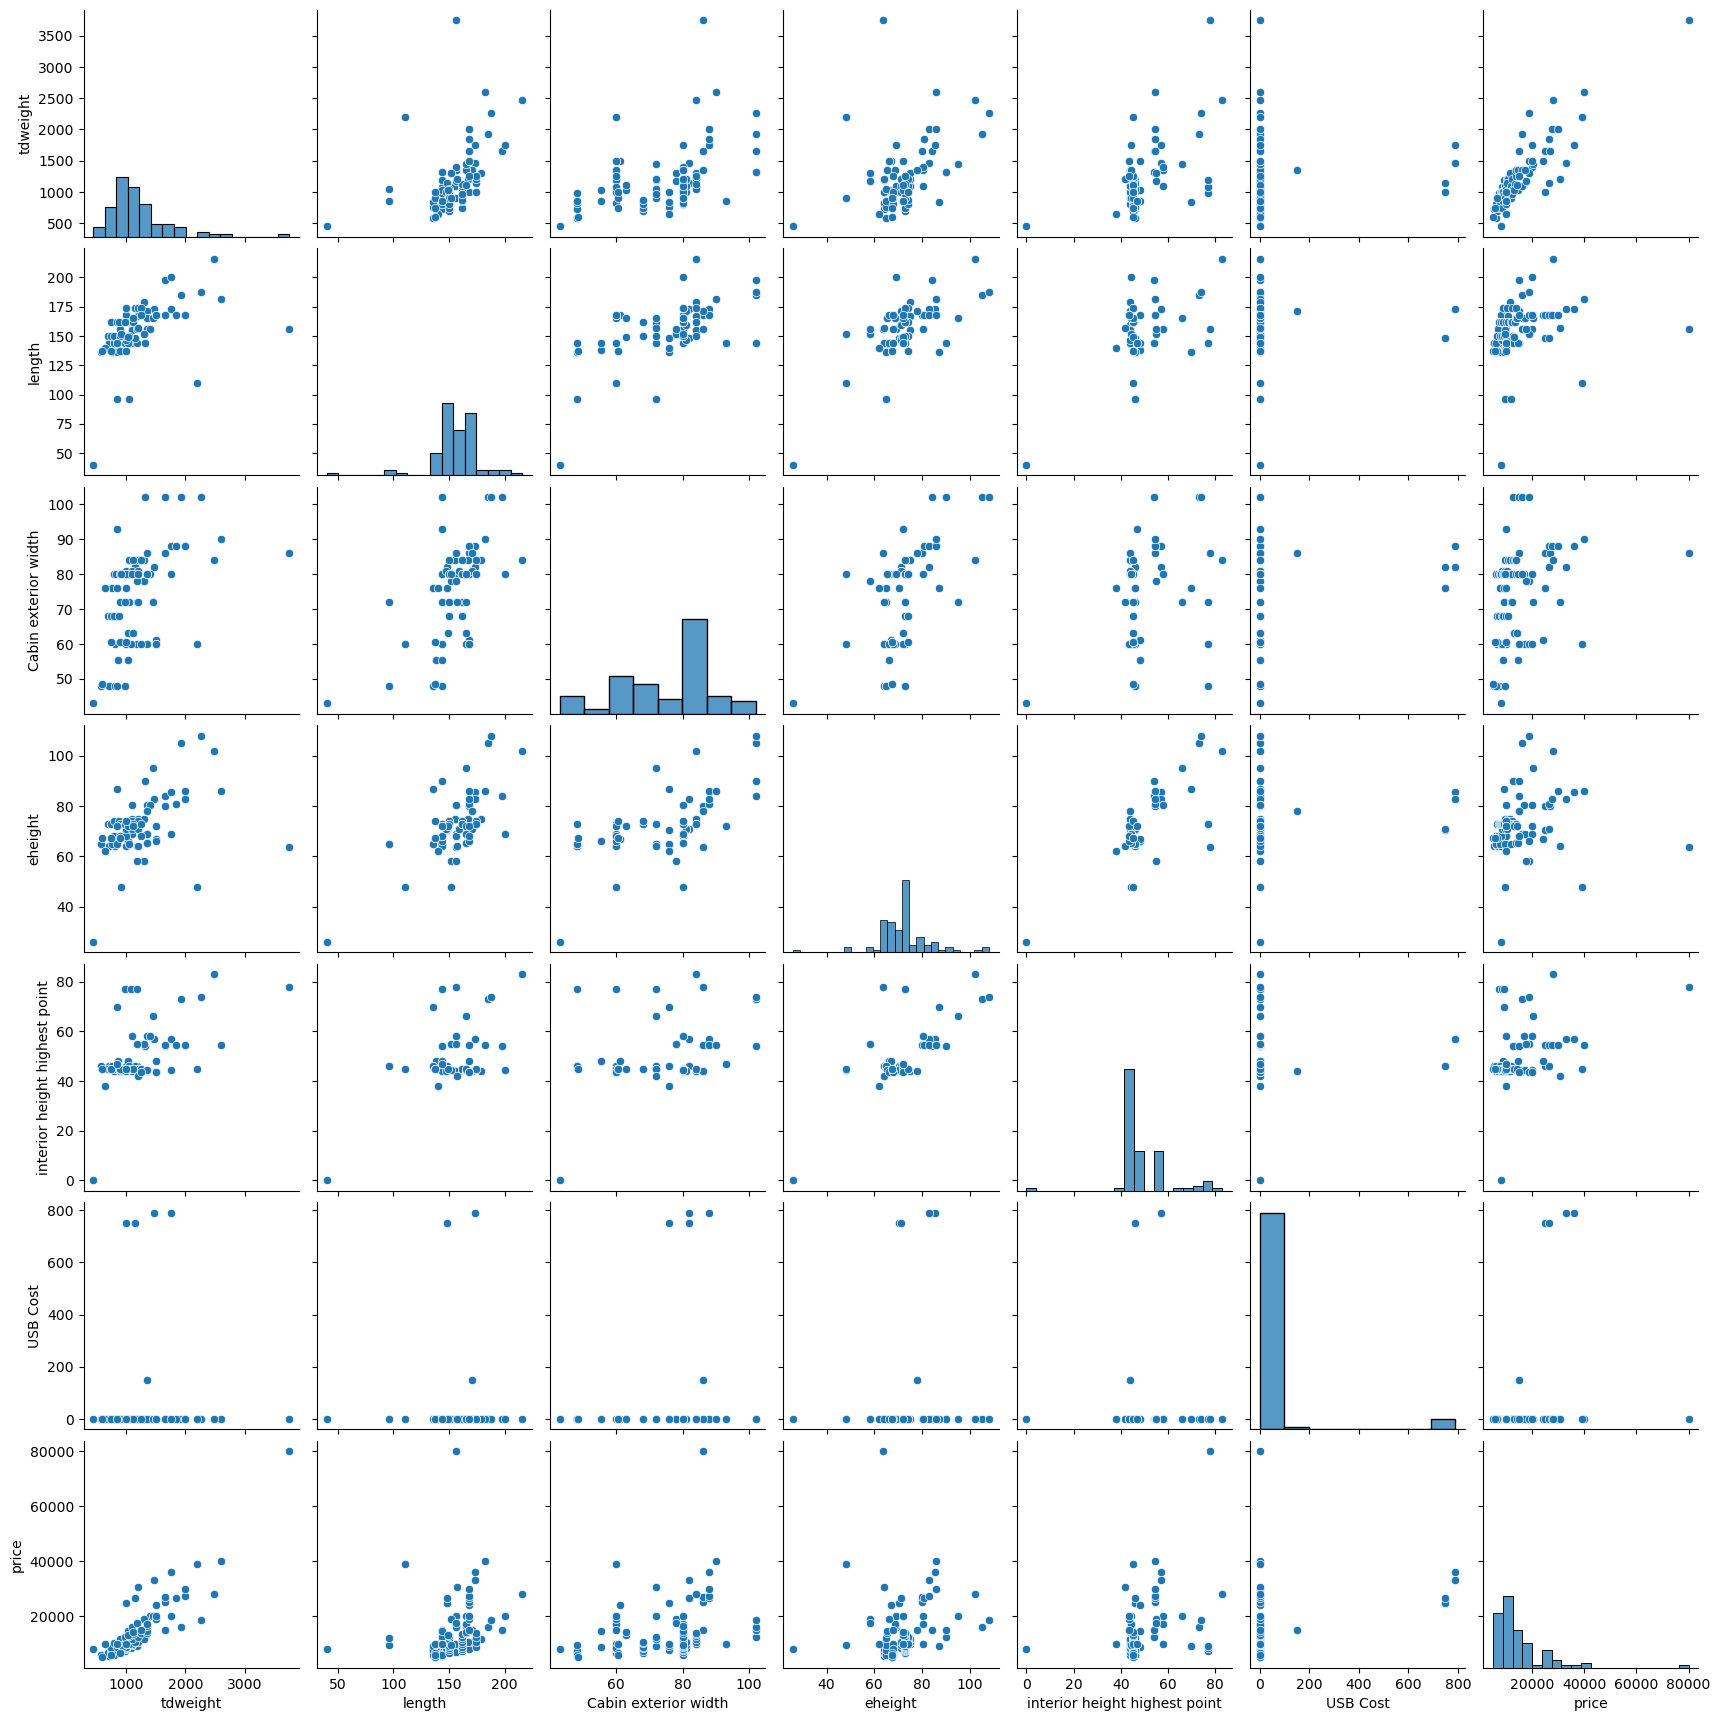

In [14]:
sns.pairplot(data)

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

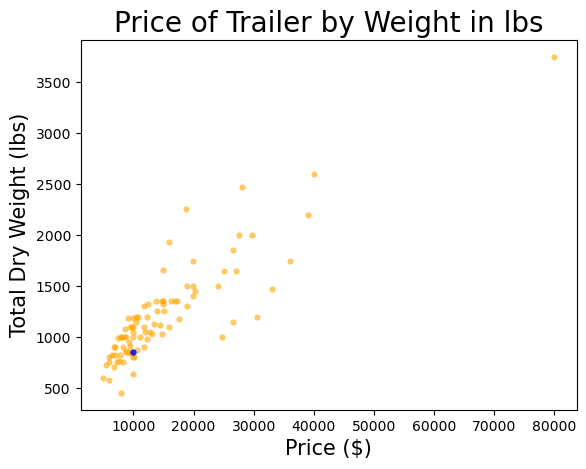

In [15]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    #the target trailer in blue
    if x[i]==9995:
        col.append('blue')  
    #all other trailers in orange
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

Now let's look at how a few features map onto the weight vs. price

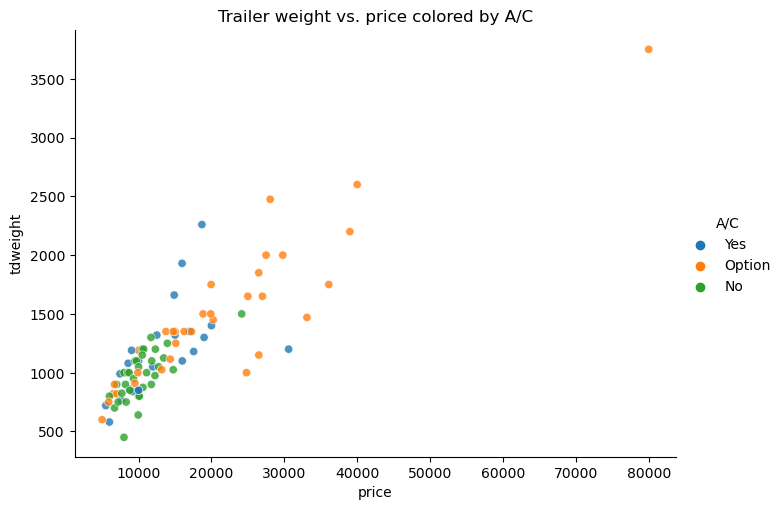

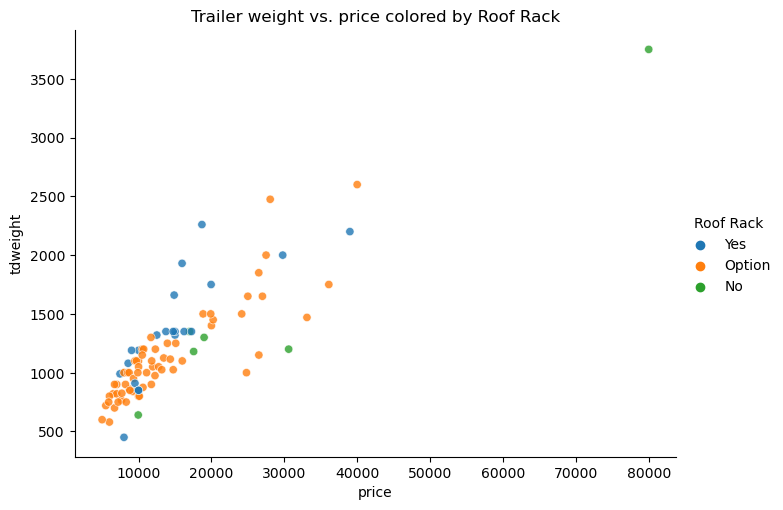

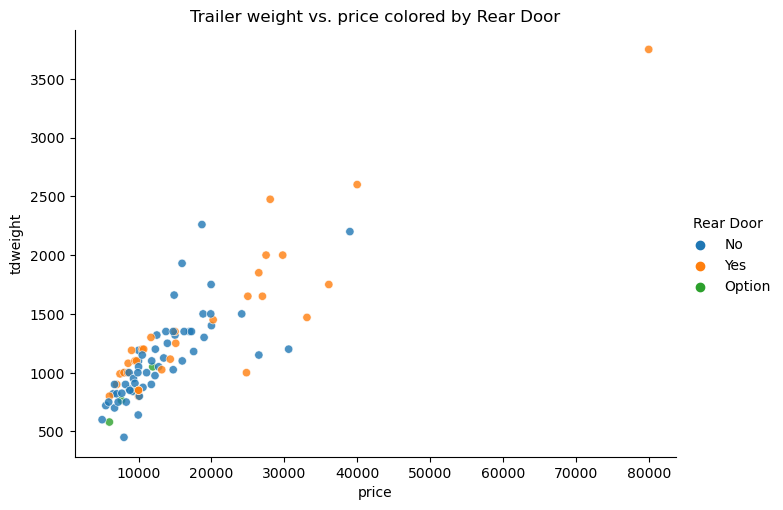

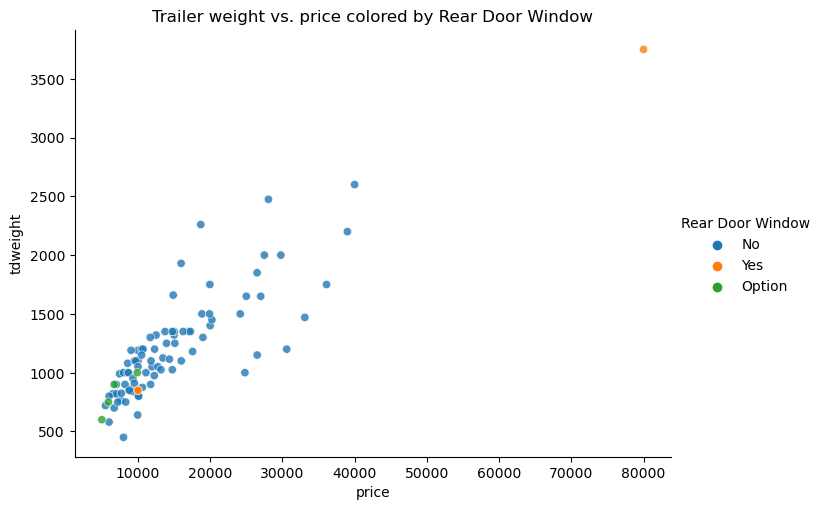

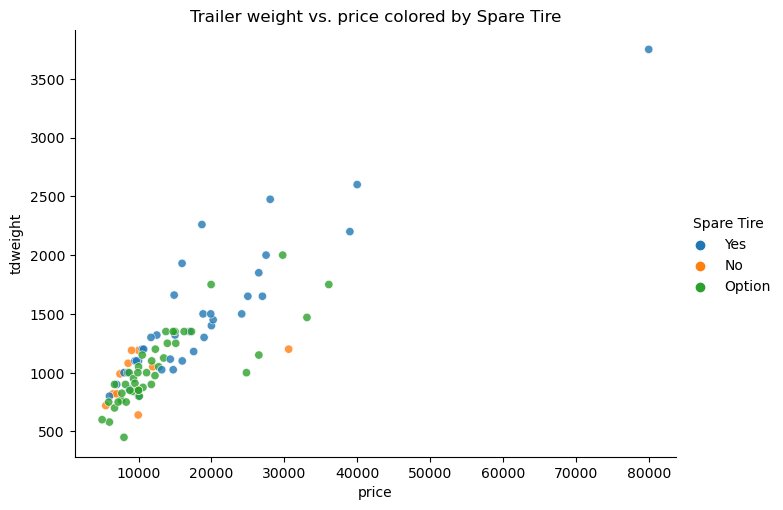

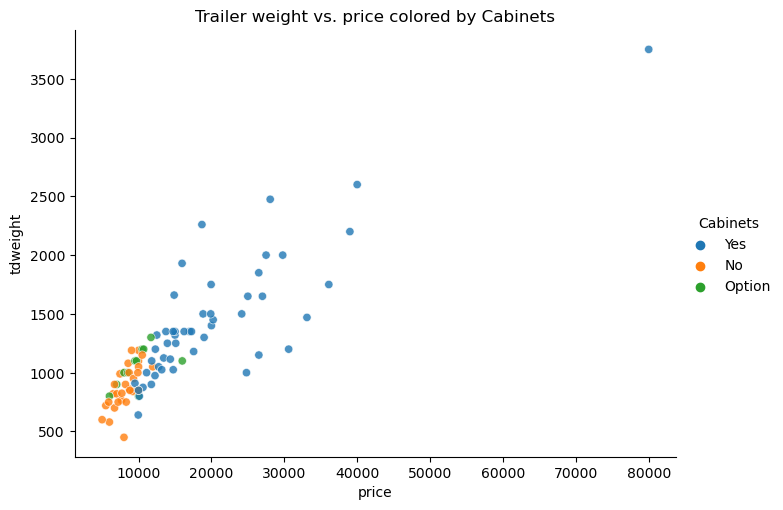

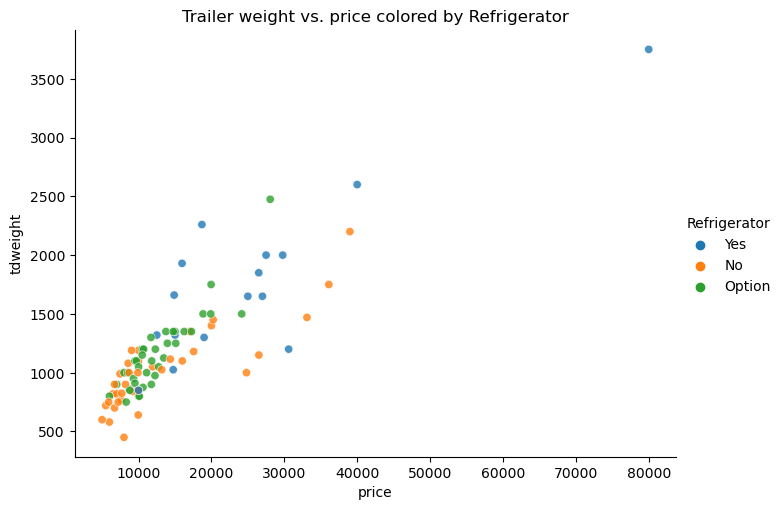

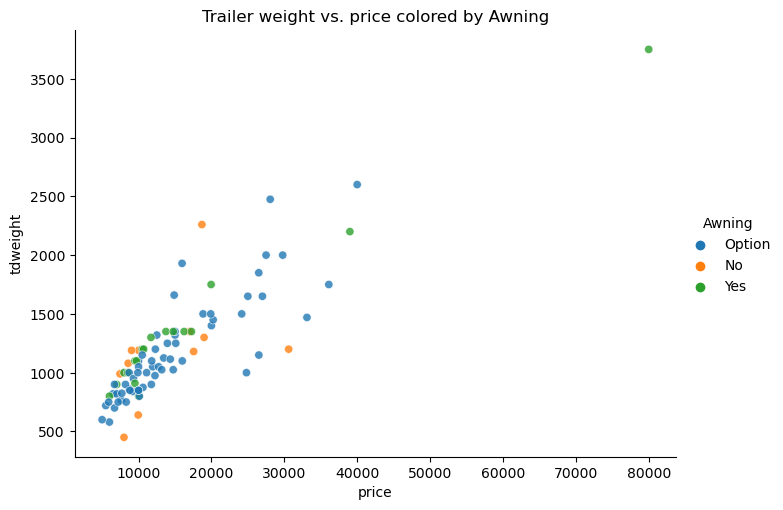

In [16]:
for c in ['A/C', 'Roof Rack', 'Rear Door', 'Rear Door Window', 'Spare Tire', 'Cabinets', 'Refrigerator', 'Awning']:
    sns.relplot(data=data, x='price', y='tdweight', hue=f"{c}", aspect=1.4, alpha=0.8)
    plt.title(f'Trailer weight vs. price colored by {c.title()}')
    plt.show()

In [17]:
#select the categorical data for encoding
cat_data = data.iloc[:, 5:26]
cat_data

,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,...,Rear Door,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,STOVE,USB Charging,USB Cost,Awning
0,84.0,54.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,...,No,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option
1,90.0,54.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,...,No,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option
2,90.0,54.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,...,No,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option
3,105.0,73.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,...,No,No,Yes,Option,Yes,Yes,Yes,Yes,0,Option
4,108.0,74.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,...,No,No,Yes,Option,Yes,Yes,Yes,Yes,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,67.5,45.0,On Road,Option,Option,Option,Option,Base,Base,Base,...,No,Option,Option,No,No,No,No,No,0,Option
88,67.5,45.0,On Road,Option,Option,Option,Option,Base,Base,Base,...,No,Option,Option,No,No,No,No,No,0,Option
89,74.0,45.0,Off Road,Option,Option,Option,Option,Base,Base,Base,...,No,Option,Option,No,No,No,No,No,0,Option
90,72.0,47.0,On Road/Off Road,Yes,Yes,No,No,Yes,Yes,Yes,...,Yes,Yes,Option,No,No,No,No,No,0,Option


In [18]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

for col in cat_data:
    data[col] = labelencoder.fit_transform(data[col])
 
data.head()

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,STOVE,USB Charging,USB Cost,Awning,price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,25,10,1,2,2,...,0,2,1,2,2,2,2,0,1,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,0,2,1,2,2,2,2,0,1,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,0,2,1,2,2,2,2,0,1,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,32,17,1,2,2,...,0,2,1,2,2,2,2,0,1,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,33,18,1,2,2,...,0,2,1,2,2,2,2,0,0,18689


In [19]:
#make a copy of the data for later
data2=data

In [20]:
corr=data2.corr()
corr

,tdweight,length,Cabin exterior width,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,Driver Side Window,Driver Side Door,...,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,STOVE,USB Charging,USB Cost,Awning,price
tdweight,1.000000,0.481744,0.445312,0.335835,0.525014,-0.186798,0.206031,0.051978,0.117287,0.005341,...,0.115983,0.419757,0.539635,0.528565,0.497908,0.633891,0.295684,0.086498,0.125630,0.871723
length,0.481744,1.000000,0.529360,0.528223,0.231782,0.000099,-0.089139,-0.017177,0.044212,0.204015,...,-0.141267,0.343122,0.348264,0.447512,0.418927,0.297667,0.464219,0.090597,0.195461,0.257258
Cabin exterior width,0.445312,0.529360,1.000000,0.602930,0.228893,0.225119,0.062363,0.125084,-0.008263,-0.141794,...,0.050795,0.433451,0.145385,0.451626,0.543677,0.331250,0.404812,0.135268,0.185846,0.291242
eheight,0.335835,0.528223,0.602930,1.000000,0.476568,-0.036759,0.069075,0.195116,0.182911,-0.145021,...,-0.109054,0.346739,0.229888,0.246790,0.301532,0.126568,0.455749,0.165206,-0.065408,0.123834
interior height highest point,0.525014,0.231782,0.228893,0.476568,1.000000,0.011610,0.522953,0.080290,0.362860,-0.127032,...,0.105139,0.112902,0.231807,0.076110,0.084460,0.244925,0.026013,0.108496,-0.360986,0.397756
Usage Intent- On or Off Road,-0.186798,0.000099,0.225119,-0.036759,0.011610,1.000000,0.214881,-0.049520,-0.020297,-0.241821,...,0.263620,0.032776,-0.300337,-0.223832,0.085402,0.138094,-0.276484,-0.224482,-0.135691,-0.188138
A/C,0.206031,-0.089139,0.062363,0.069075,0.522953,0.214881,1.000000,0.213740,0.172473,-0.412145,...,0.182842,-0.097104,0.052542,0.022414,-0.073782,0.361604,-0.123967,0.037686,-0.376404,0.159115
Roof Rack,0.051978,-0.017177,0.125084,0.195116,0.080290,-0.049520,0.213740,1.000000,-0.190680,-0.109034,...,0.019313,-0.126616,0.187547,-0.002249,0.103687,0.235605,0.212053,-0.031596,0.145949,-0.168410
Driver Side Window,0.117287,0.044212,-0.008263,0.182911,0.362860,-0.020297,0.172473,-0.190680,1.000000,-0.103572,...,-0.143702,-0.040452,0.014409,-0.020188,0.168432,-0.047882,0.057212,-0.293523,-0.401604,-0.004463
Driver Side Door,0.005341,0.204015,-0.141794,-0.145021,-0.127032,-0.241821,-0.412145,-0.109034,-0.103572,1.000000,...,-0.337809,-0.283964,0.124036,0.104907,0.038495,-0.071141,0.087881,0.138645,-0.045647,0.069668


<AxesSubplot:>

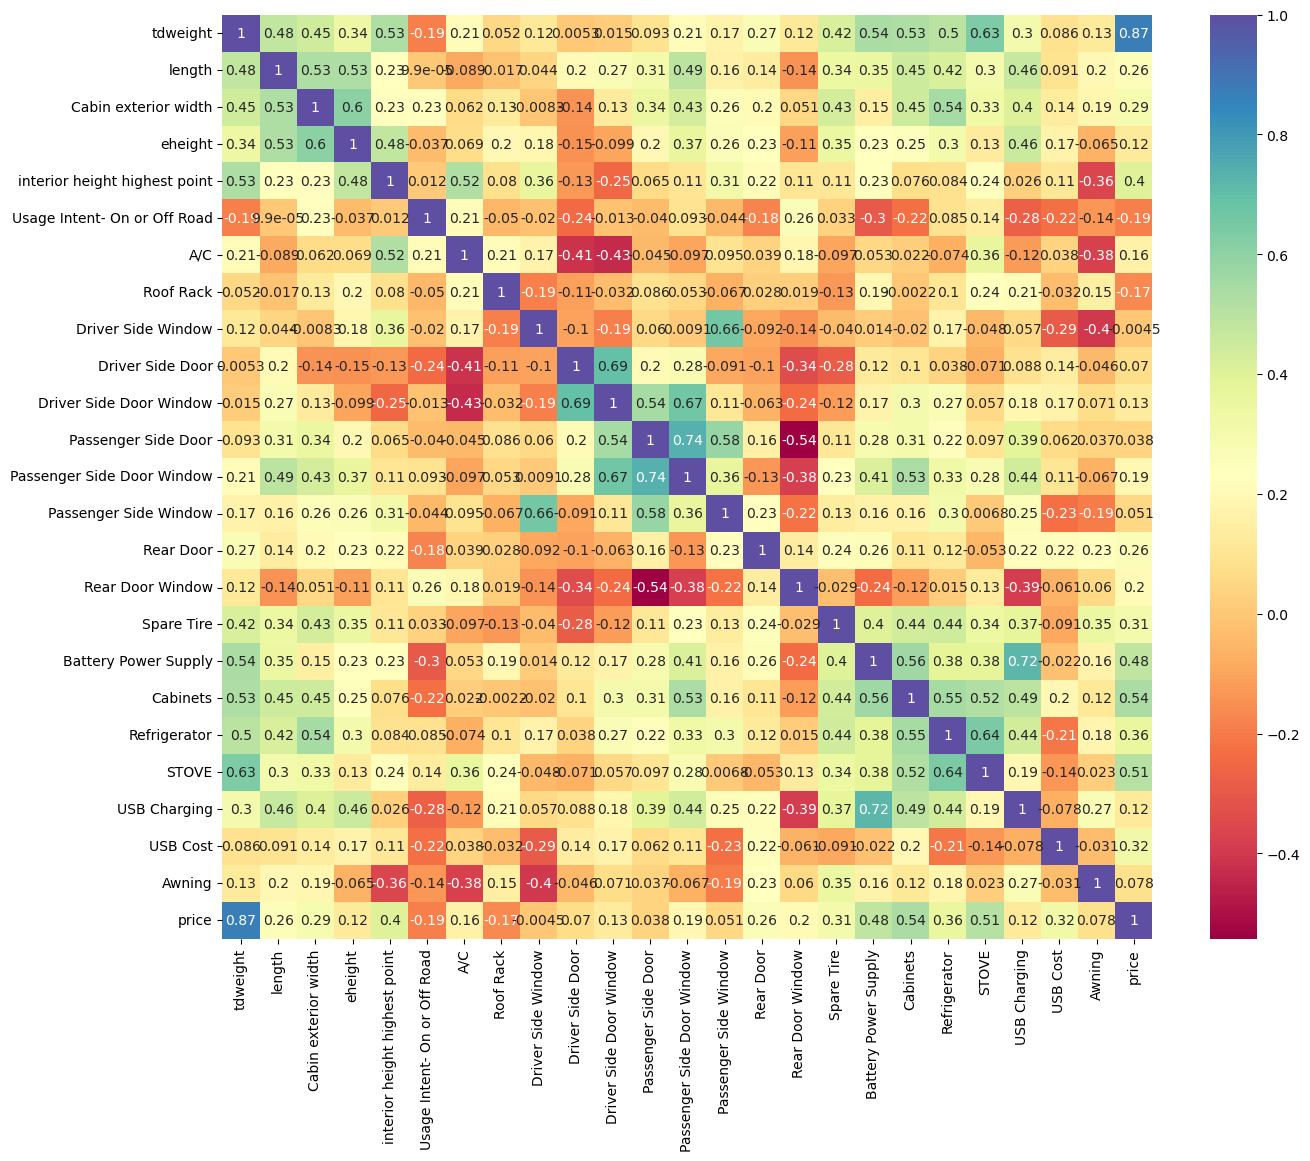

In [21]:
plt.figure(figsize=(15,12))
sns.heatmap(corr,annot=True,cmap="Spectral")

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

#Replace "option" with "no" and try modeling again

In [22]:
data2=data2.drop(data.index[93:])

In [23]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price', 'Manufacturer', 'model'],axis=1)
y=data2['price']

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [25]:
#scaling the data
#this usually helps with modeling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16) 

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output metrics 

R^2 :  0.9308575154465891
MAE : 1706.0661113058375
RMSE: 2114.5695176123154


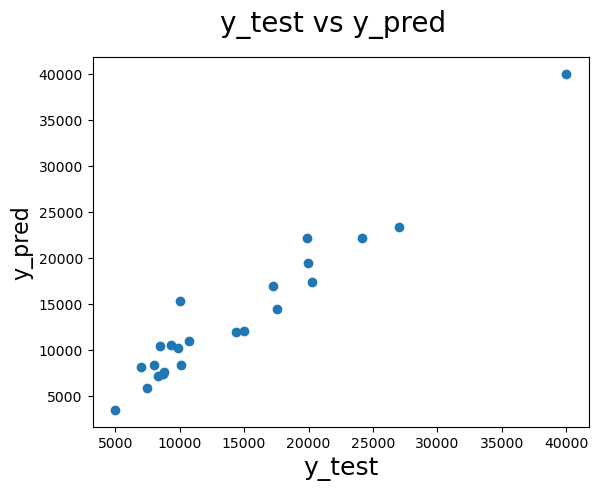

In [27]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.3279695654612974
MAE : 3806.8260869565215
RMSE: 6592.406023138521


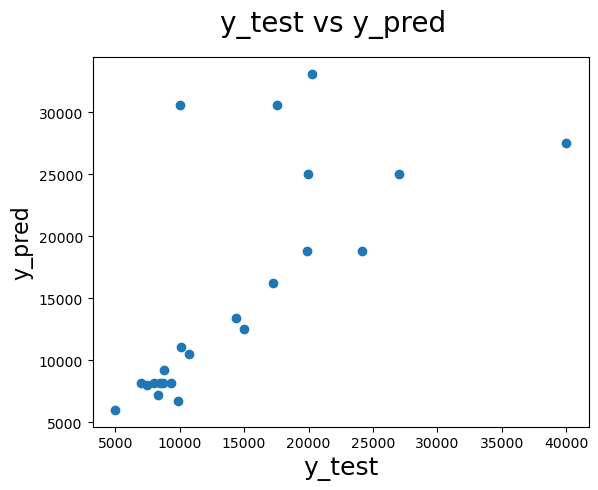

In [28]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.6347585903307946
MAE : 3376.8992568465696
RMSE: 4860.035950885494


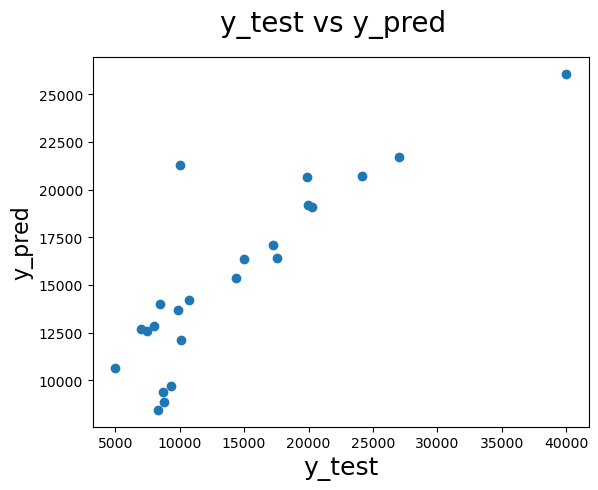

In [29]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.8245029440361439
MAE : 2504.171835642235
RMSE: 3368.87110089503


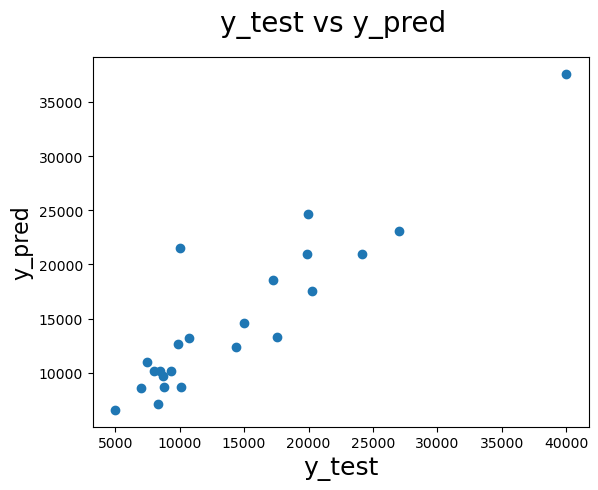

In [30]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.9241237839524858
MAE : 1768.986472998051
RMSE: 2215.145760993859


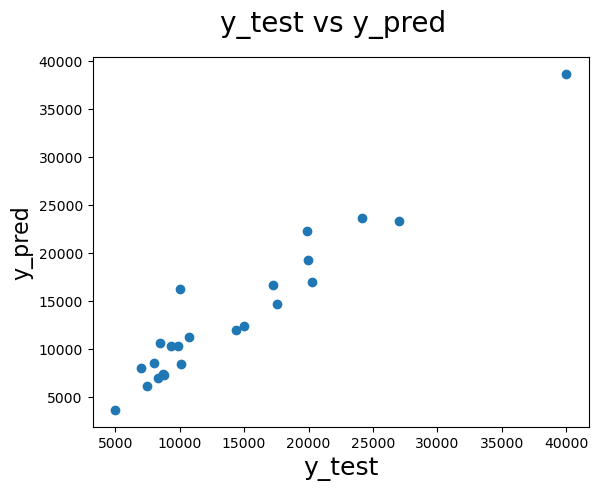

In [31]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


R^2 :  0.9309342136491752
MAE : 1706.3231748332632
RMSE: 2113.3963699887354


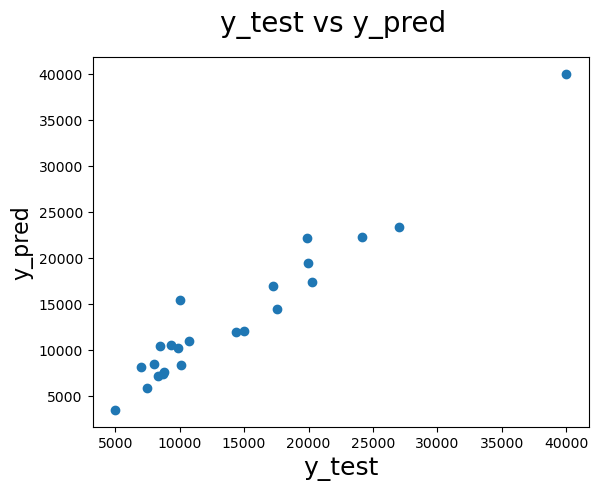

In [32]:
model_6 = LassoLars(alpha=.1)
run_experiment(model_6)

R^2 :  0.9184095709456106
MAE : 1801.9022230555727
RMSE: 2297.042788615627


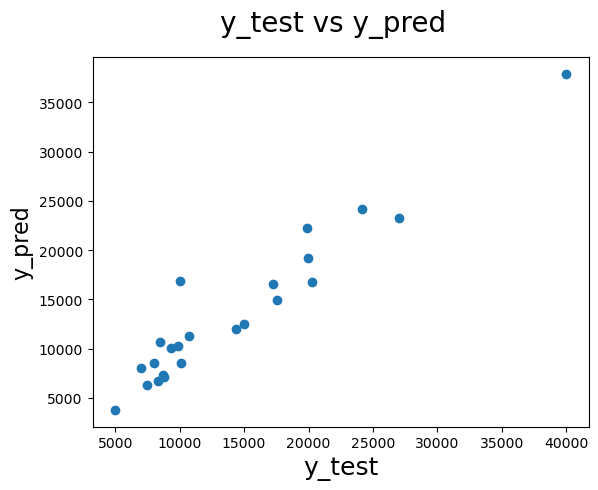

In [33]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.9134253636106435
MAE : 1930.1971383464293
RMSE: 2366.163849138925


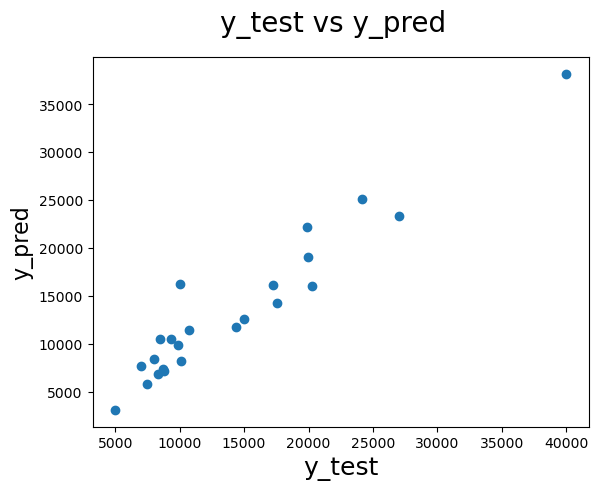

In [34]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.09013604553486987
MAE : 6041.720088553753
RMSE: 8396.336329498536


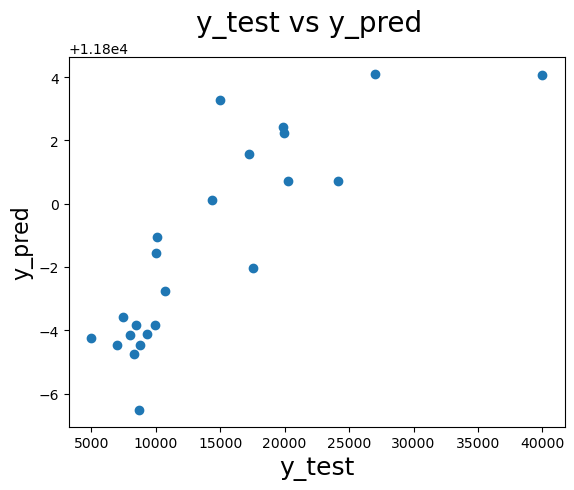

In [35]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.8981648966569123
MAE : 1873.8574926908843
RMSE: 2566.2456779140807


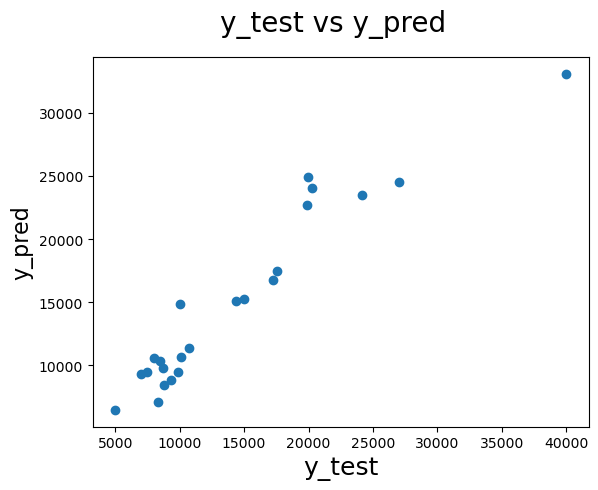

In [36]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

Unsurprisingly, RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance

The features which have been included thus far are based on features that have enough data available online to realistically include, and picking out which ones are actually important is still in progress. Currently, a more novel feature information (e.g. solar panels) are being mined, while others whihc are already included need to be optimized. One feature which is currently in process of engineering is the number of doors and if they include windows. the information is currently held in 4 seperate columns which have low correlation to the price, and should be combined into a single column containing all of the information to improve calculations. 

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price', 'Manufacturer', 'model'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the columns
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(20,'Score'))  

                            Specs         Score
0                        tdweight  18170.249562
3                         eheight    355.418705
1                          length    277.566500
4   interior height highest point    228.085635
22                       USB Cost    214.818182
2            Cabin exterior width    205.700203
15               Rear Door Window    132.600000
20                          STOVE    108.219512
14                      Rear Door    104.060606
6                             A/C     62.025000
18                       Cabinets     60.981982
19                   Refrigerator     58.800000
8              Driver Side Window     54.563025
21                   USB Charging     53.115702
17           Battery Power Supply     49.222222
5    Usage Intent- On or Off Road     49.117647
9                Driver Side Door     41.261538
10        Driver Side Door Window     33.975610
16                     Spare Tire     28.076923
23                         Awning     23

[0.20540795 0.13515373 0.1161756  0.09615694 0.04171601 0.04521843
 0.02217751 0.0246212  0.0209272  0.02554523 0.02414414 0.00751249
 0.01523167 0.02059555 0.02127127 0.01105251 0.0276319  0.02293089
 0.02697083 0.0228317  0.01858377 0.0165954  0.00866929 0.02287878]


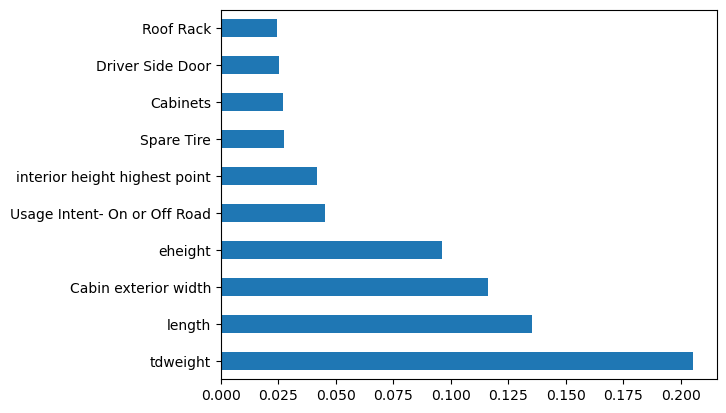

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

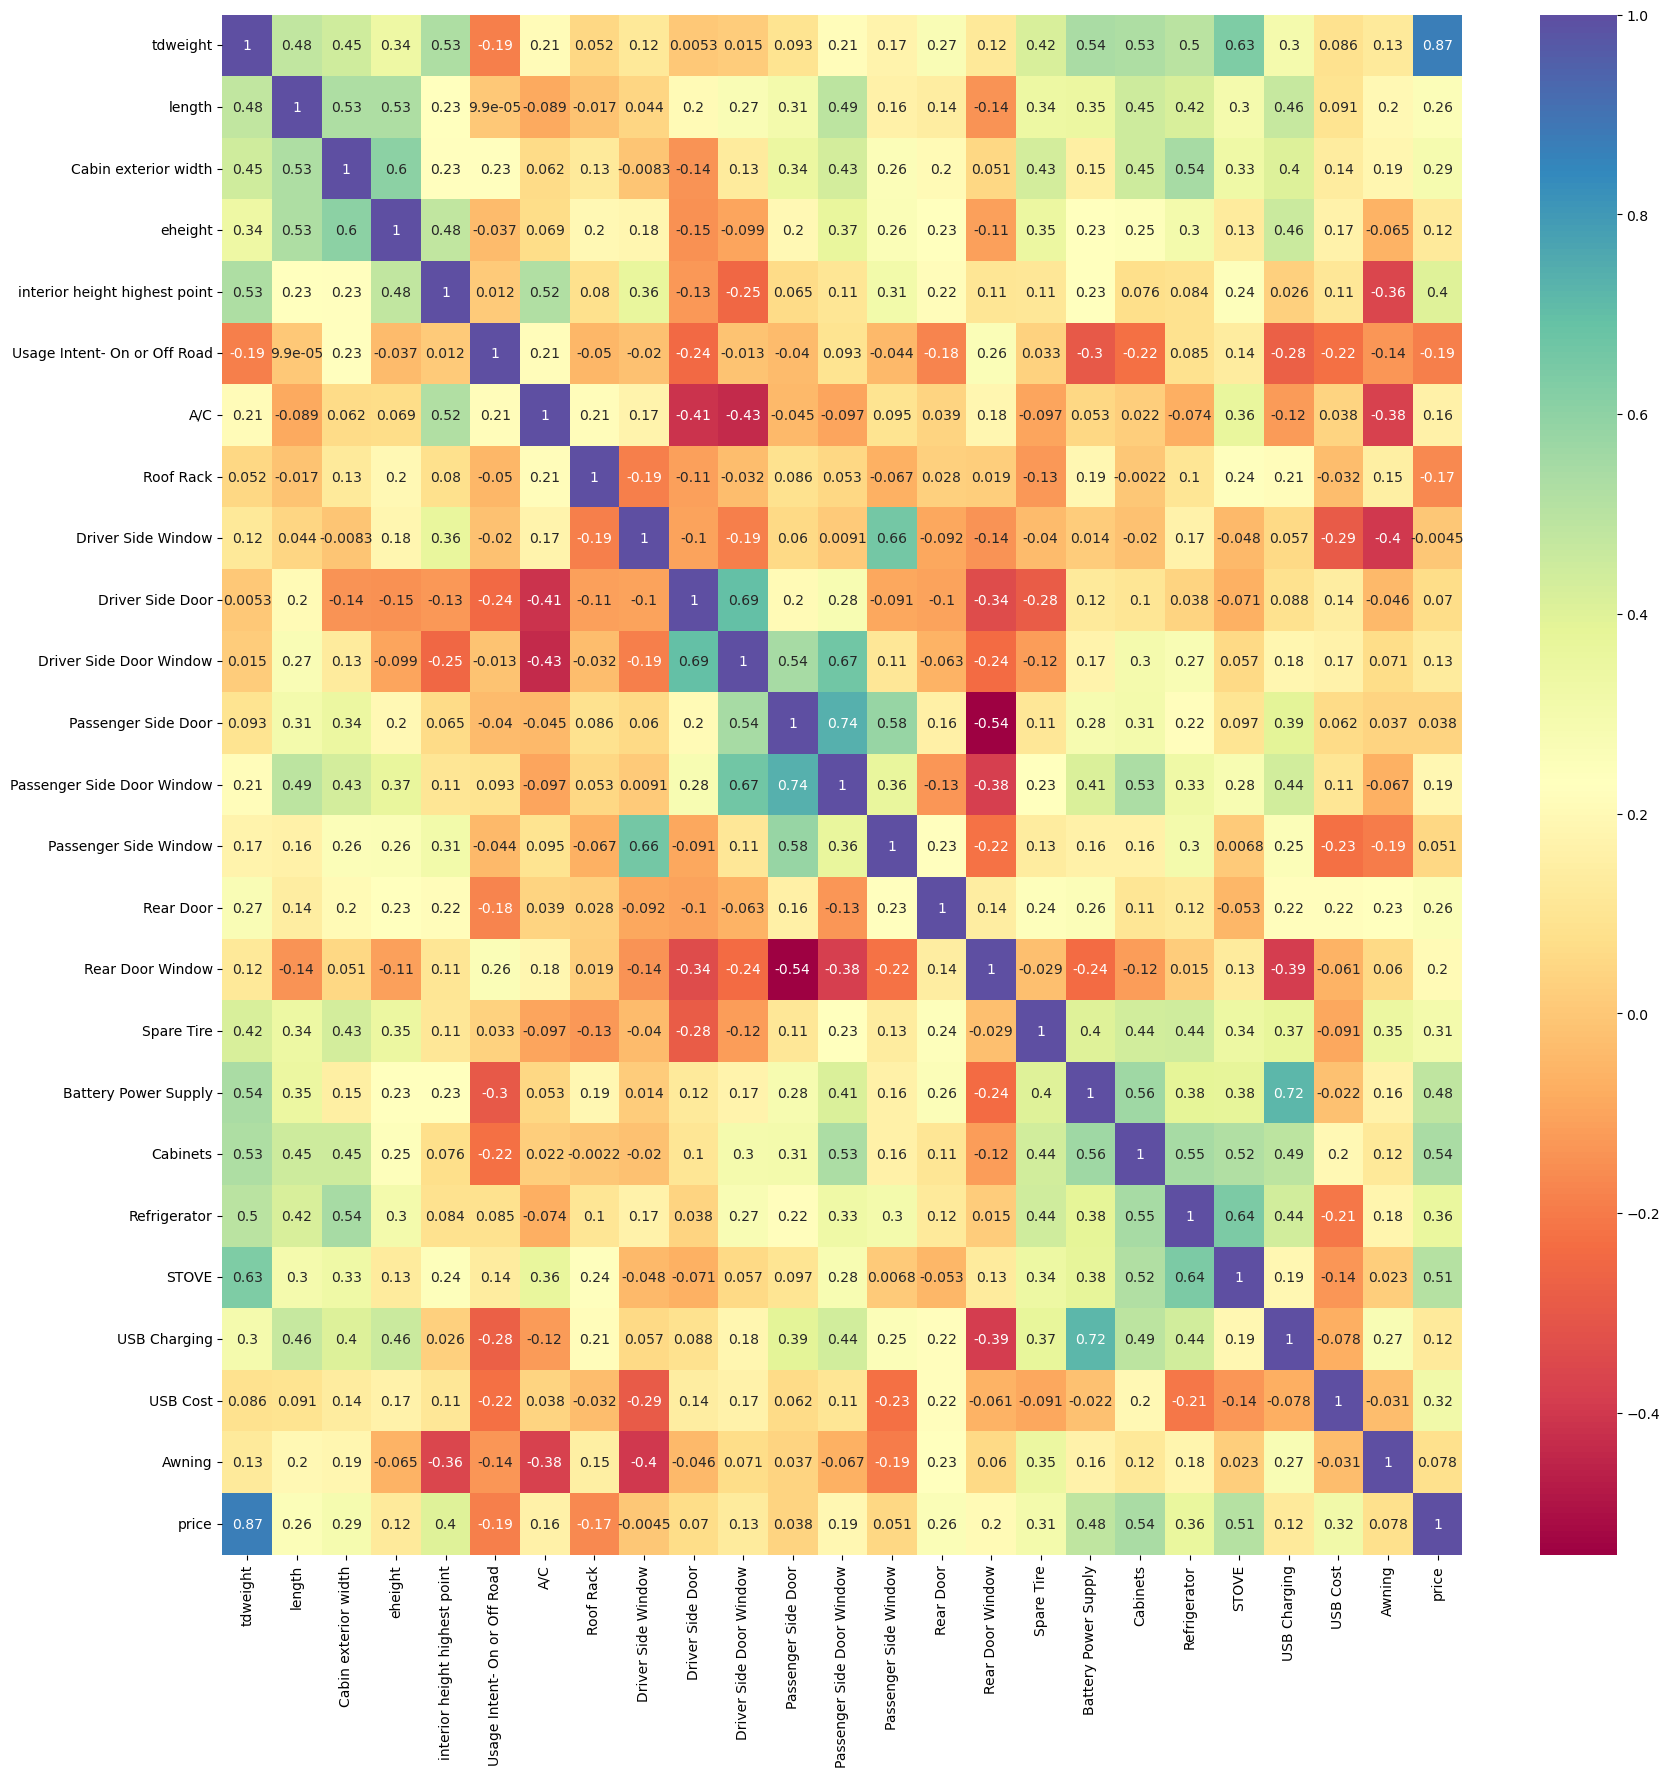

In [39]:
#get correlations of each features in dataset
corrmat = data2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="Spectral")

# Feature Engineering
This section is in progress while more feature data is collected.

In [40]:
data3=data.drop(data.index[90:92])

In [41]:
data3

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,STOVE,USB Charging,USB Cost,Awning,price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,25,10,1,2,2,...,0,2,1,2,2,2,2,0,1,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,0,2,1,2,2,2,2,0,1,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,0,2,1,2,2,2,2,0,1,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,32,17,1,2,2,...,0,2,1,2,2,2,2,0,1,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,33,18,1,2,2,...,0,2,1,2,2,2,2,0,0,18689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Aero Teardrops,The Burnside,1250,168.0,60.0,11,3,0,1,1,...,0,1,2,2,1,1,2,0,1,15099
86,MyMiniTrailer,Carpe Diem Mini,600,137.0,48.5,10,6,1,1,1,...,1,1,0,0,0,0,0,0,1,4995
87,MyMiniTrailer,Gypsy,900,137.0,60.5,10,6,1,1,1,...,1,1,0,0,0,0,0,0,1,6700
88,MyMiniTrailer,Serenity X,750,137.0,60.5,10,6,1,1,1,...,1,1,0,0,0,0,0,0,1,5900


In [42]:
#removing everything with a negative correlation
X = data3.drop(['price', 'Roof Rack', 'Driver Side Window', 'Usage Intent- On or Off Road', 'Manufacturer', 'model'],axis=1)
y=data3['price']

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [44]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16) 

R^2 :  0.7095951943617111
MAE : 2618.2489867988234
RMSE: 4590.929481578685


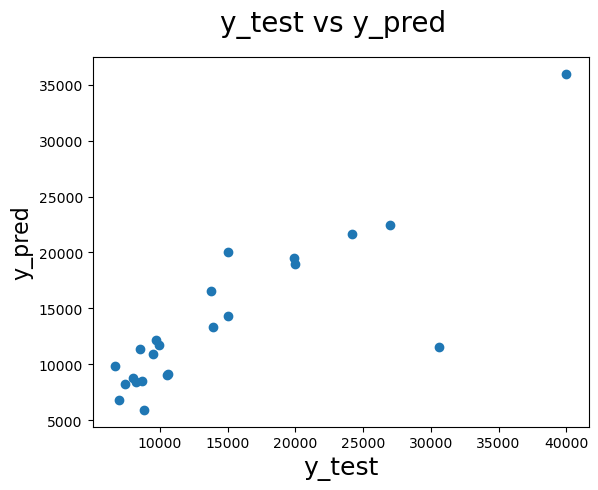

In [46]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.4784526704499529
MAE : 3844.4347826086955
RMSE: 6152.414478320156


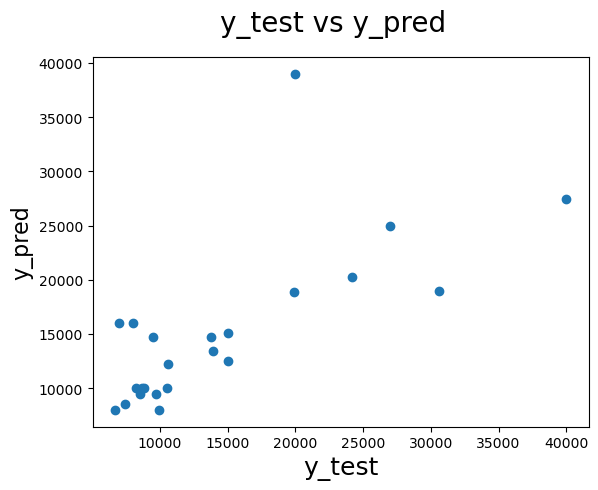

In [47]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.5617370197293328
MAE : 4250.275675612958
RMSE: 5639.831337232508


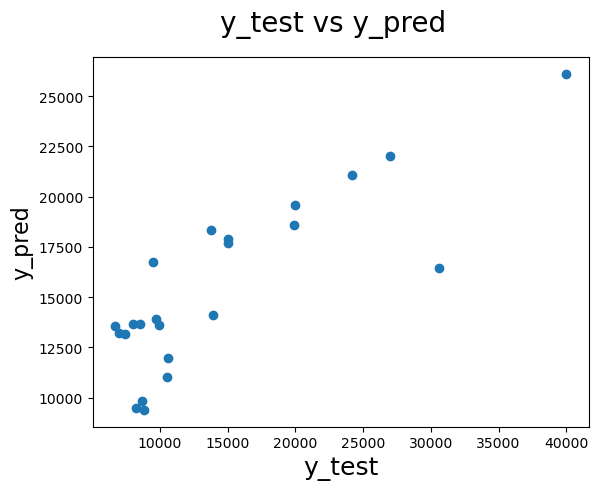

In [48]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.7368826568603488
MAE : 3256.9446314256184
RMSE: 4369.919734645598


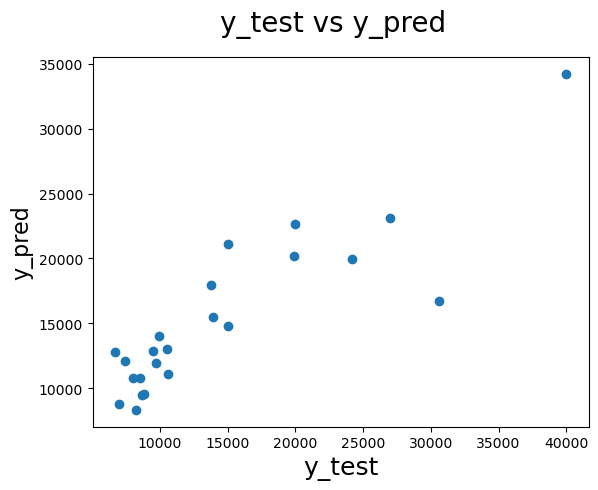

In [49]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7004174340802856
MAE : 2699.747109226596
RMSE: 4662.909543255354


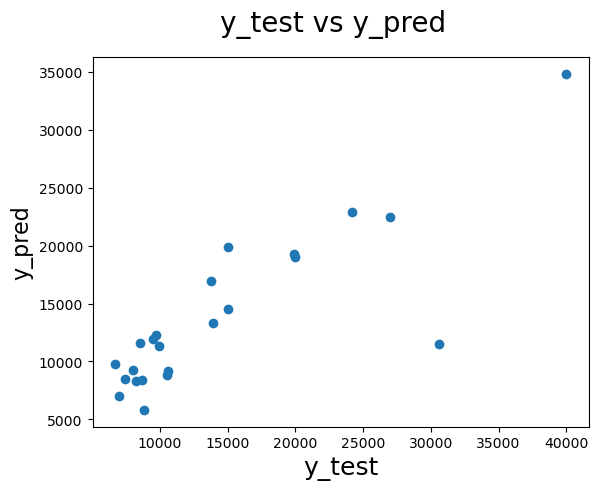

In [50]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7005096021505607
MAE : 2698.0645713109507
RMSE: 4662.192204391588


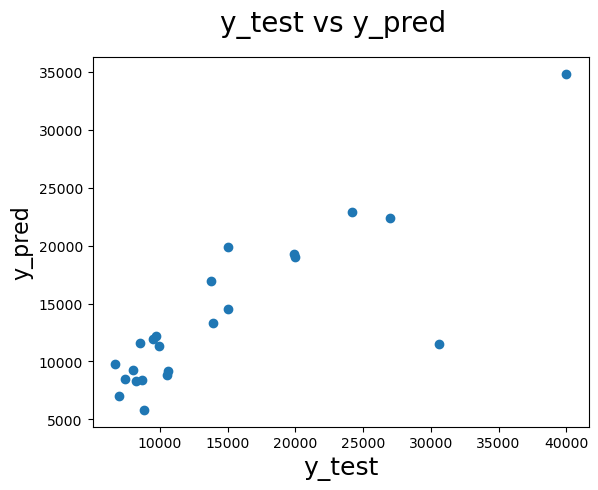

In [51]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.687401475194463
MAE : 2724.07071848663
RMSE: 4763.127254965825


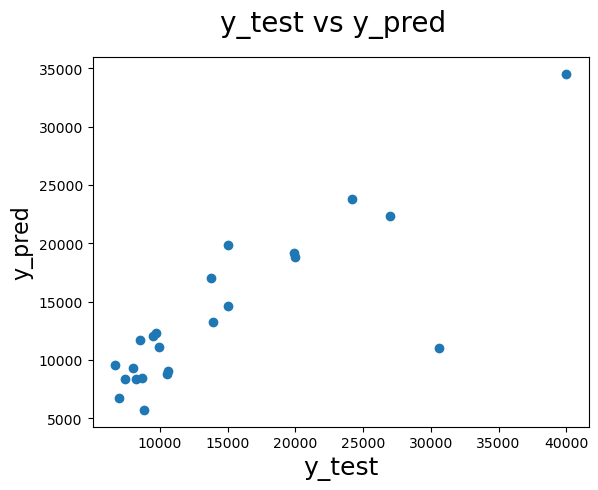

In [52]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.08680612396906762
MAE : 6152.13707685239
RMSE: 8881.263612870442


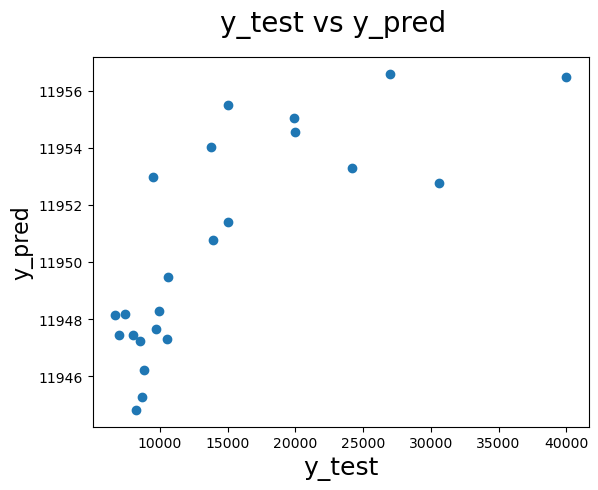

In [53]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7234537108147698
MAE : 2912.3773339184977
RMSE: 4480.0477214611965


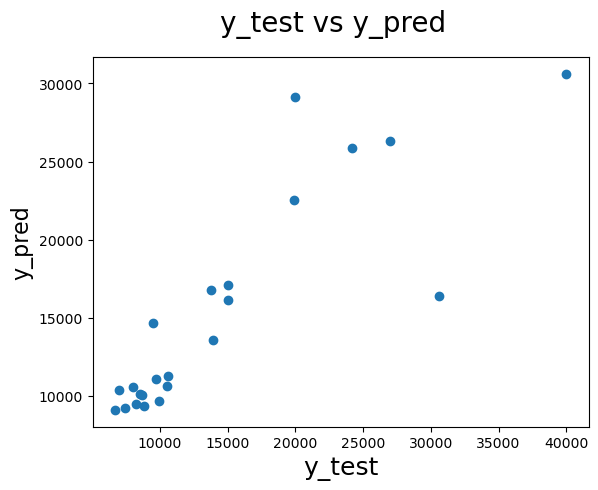

In [54]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

[0.21589893 0.14594085 0.12744654 0.11519719 0.04651032 0.02421102
 0.0243434  0.02322696 0.00883816 0.02124184 0.02463237 0.0230755
 0.00413948 0.0298217  0.02523422 0.0293819  0.02644034 0.01883222
 0.01954793 0.01063664 0.03540249]


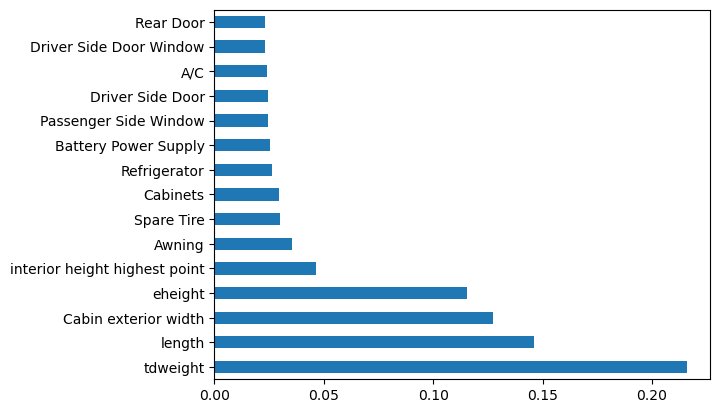

In [55]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [56]:
rfc=RandomForestRegressor(random_state=1)

In [57]:
param_grid = { 
    'n_estimators': [100, 500, 1000, 5000],
    'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
     'max_depth' : [5, 10, 15],
    # 'min_samples_leaf' : [1,2,3,5],
     #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [58]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500, 1000, 5000]})

In [59]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}

R^2 :  0.7309875549955642
MAE : 2704.4949275362314
RMSE: 4418.6022395112695


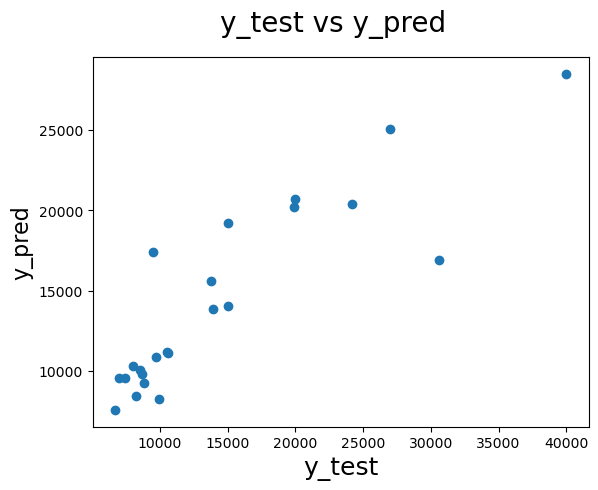

In [60]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(criterion= 'squared_error', n_estimators=100, max_features='sqrt', max_depth=15, min_samples_leaf=1, random_state=1)
run_experiment(final_model)

# Checking the value of interest

In [61]:
new_input = data.loc[90:92]
new_input

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,STOVE,USB Charging,USB Cost,Awning,price
90,XYZ Camping,NaN,850,144.0,93.0,16,8,2,2,2,...,2,1,0,0,0,0,0,0,1,9995
91,XYZ Camping,NaN,850,144.0,93.0,16,8,2,2,2,...,2,1,0,2,2,2,0,0,1,9995


In [62]:
#drop the variable to be predicted
new_input=new_input.drop(['price', 'Roof Rack', 'Driver Side Window', 'Usage Intent- On or Off Road', 'Manufacturer', 'model'],axis=1)
new_input

,tdweight,length,Cabin exterior width,eheight,interior height highest point,A/C,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,...,Rear Door,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,STOVE,USB Charging,USB Cost,Awning
90,850,144.0,93.0,16,8,2,0,3,2,3,...,2,2,1,0,0,0,0,0,0,1
91,850,144.0,93.0,16,8,2,0,3,2,3,...,2,2,1,0,2,2,2,0,0,1


In [63]:
new_input_scaled = scaler.fit_transform(new_input)

In [64]:
new_output = final_model.predict(new_input_scaled)
new_output

array([11481.11, 15912.97])

# Notes on the metrics used
✔️ Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑦̂𝑖|
1
n
∑
i
=
1
n
|
y
i
−
y
^
i
|
 

 
Mean Squared Error (MSE) is the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
📌 Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm?scriptVersionId=117768677&cellId=36

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>